In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
# from numpy.lib.stride_tricks import broadcast_to
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import jupyter
import matplotlib
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
def unicodeToAscii(s):
    return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    )


# 其中normalizeString函数中的正则表达式需对应更改，否则会将中文单词替换成空格
def normalizeString(s):
    #变成小写，去掉前后空格
    s = s.lower().strip()
    if ' ' not in s:
        s = list(s)
        s = ' '.join(s)
    s = unicodeToAscii(s)  #将unicode变成ascii
    s = re.sub(r"([.。!！?？])", "", s)
    return s


In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_path = "./data/eng-cmn.txt"
    with open(file_path, encoding='utf-8') as file:
        lines = file.readlines()
    

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]


    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs



In [7]:
input_lang, output_lang, pairs = prepareData('eng', 'cmn', True)
print(random.choice(pairs))


Reading lines...
Read 24026 sentence pairs
Trimmed to 459 sentence pairs
Counting words...
Counted words:
cmn 684
eng 560
['他 们 不 怕 死 ', "they aren't afraid of death"]


In [8]:
'''file_path = "./data/eng-cmn.txt"
with open(file_path, encoding='utf-8') as file:
    lines = file.readlines()
pairs = [[normalizeString(l).split('\t')[:2]] for l in lines]
cn = []
eng = []
for p in pairs:
    p=np.array(p)
    eng.append([p[0,0]])
    cn.append([p[0,1]])'''

'file_path = "./data/eng-cmn.txt"\nwith open(file_path, encoding=\'utf-8\') as file:\n    lines = file.readlines()\npairs = [[normalizeString(l).split(\'\t\')[:2]] for l in lines]\ncn = []\neng = []\nfor p in pairs:\n    p=np.array(p)\n    eng.append([p[0,0]])\n    cn.append([p[0,1]])'

# The Encoder

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Attention Decoder

In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Preparing Training Data

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Training the model

In [12]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [13]:
#This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [14]:
# jetML平台配置

from pzmllog import NewLogger

learning_rate = 0.01
epoch = 1
batch_size = 1


log = NewLogger(
    config={
  
        #实验描述和说明信息
        "description":"lab4train",
        #自定义实验名称
        "experiment_name":"lab4",
        'port': "5560",
        'access_token':"oe9f7l5ax53saarwz0ss1wss",
        'project':"1698",
        'repository_id':"a68dac18203a47ed9f35512f4cee5bad"
    },
    #超参数集
    info = {
        "learning_rate": learning_rate,
        "epoch": epoch,
        "batch_size": batch_size
    }
)

In [15]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        # log.Log({"epoch":epoch,"loss":loss,"accuracy":accuracy})
        log.Log({"epoch":epoch,"loss":loss})

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


# Plotting results

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

# Evaluation

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [18]:
def evaluateRandomly(encoder, decoder, n=100):
    sum_scores = 0
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        w = []
        words = pair[1].strip(' ').split(' ')
        words.append('<EOS>')
        w.append(words)
        bleu_score = sentence_bleu(w, output_words)
        sum_scores += bleu_score
    print('The bleu_score is ', sum_scores/n)

# Training and Evaluating

2m 19s (- 32m 26s) (5000 6%) 2.3208
4m 28s (- 29m 6s) (10000 13%) 0.5710
6m 37s (- 26m 31s) (15000 20%) 0.0879
8m 47s (- 24m 9s) (20000 26%) 0.0537
10m 56s (- 21m 52s) (25000 33%) 0.0427
13m 5s (- 19m 38s) (30000 40%) 0.0346
15m 15s (- 17m 26s) (35000 46%) 0.0357
17m 25s (- 15m 14s) (40000 53%) 0.0352
19m 32s (- 13m 1s) (45000 60%) 0.0374
21m 38s (- 10m 49s) (50000 66%) 0.0295
23m 43s (- 8m 37s) (55000 73%) 0.0350
25m 49s (- 6m 27s) (60000 80%) 0.0314
27m 54s (- 4m 17s) (65000 86%) 0.0332
30m 8s (- 2m 9s) (70000 93%) 0.0327
32m 24s (- 0m 0s) (75000 100%) 0.0306


<Figure size 640x480 with 0 Axes>

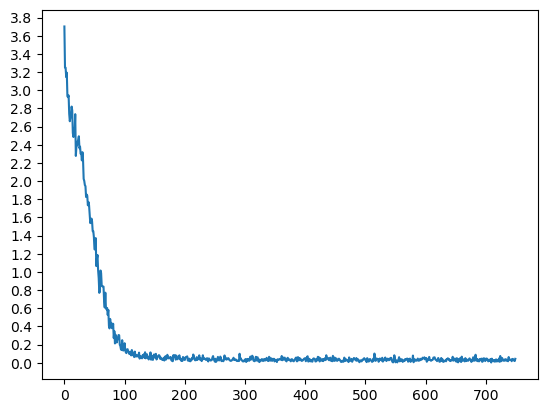

In [19]:
hidden_size = 256
from nltk.translate.bleu_score import sentence_bleu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

log.Run()
# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
# trainIters(encoder1, attn_decoder1, 1000, print_every=100, learning_rate=learning_rate)
trainIters(encoder1, attn_decoder1, 75000, print_every=5000, learning_rate=learning_rate)
log.End()

# 结束整个过程,提交实验结果

log.Submit()

In [20]:
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
evaluateRandomly(encoder1, attn_decoder1)

> 他 是 一 個 怪 人 
= he is a screwball
< you are not a coward <EOS>

> 他 一 天 一 天 地 好 轉 
= he is getting better day by day
< you are not a coward <EOS>

> 他 依 旧 充 满 活 力 
= he is still very much alive
< you are not authorized to <EOS>

> 她 陶 醉 在 幸 福 裡 
= she is drunk with happiness
< he is poor at rugby <EOS>

> 我 六 英 尺 高 
= i am six feet tall
< he is poor at all wrong <EOS>

> 我 們 身 處 核 能 時 代 
= we are in the era of atomic energy
< he is poor at rugby <EOS>

> 他 和 我 同 岁 
= he is just my age
< you are not a coward <EOS>

> 他 跟 我 過 不 去 
= he is giving me a hard time
< you are absolutely right this subject <EOS>

> 我 为 我 父 亲 而 自 豪 
= i am proud of my father
< he is not a dj <EOS>

> 我 在 下 一 站 下 车 
= i am getting off at the next station
< he is poor at chemistry <EOS>

> 我 將 主 修 法 文 
= i am going to major in french
< he is poor at her <EOS>

> 他 缺 乏 常 识 
= he is lacking in common sense


C:\Users\Lenovo\.conda\envs\jetML\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Lenovo\.conda\envs\jetML\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Lenovo\.conda\envs\jetML\lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

< you are not a coward <EOS>

> 他 怕 蛇 
= he is afraid of snakes
< you are not authorized to <EOS>

> 她 在 节 食 
= she is dieting
< he is poor at rugby <EOS>

> 他 们 是 我 的 兄 弟 
= they are my brothers
< you are not a coward <EOS>

> 她 现 在 正 在 吃 午 餐 
= she is having lunch now
< you are absolutely right now <EOS>

> 他 害 怕 蛇 
= he is afraid of snakes
< you are not authorized to <EOS>

> 他 們 是 高 中 生 
= they are high school students
< you are not a coward <EOS>

> 我 是 匈 牙 利 人 
= i am hungarian
< he is poor at chemistry <EOS>

> 他 不 是 傻 子 
= he is no fool
< you are absolutely right this subject <EOS>

> 你 對 批 評 太 敏 感 了 
= you are too sensitive to criticism
< he is poor at the game <EOS>

> 我 们 非 常 需 要 食 物 
= we are badly in need of food
< he is mean to arrive a <EOS>

> 他 今 天 在 家 
= he is at home today
< you are absolutely right this subject <EOS>

> 他 很 高 
= he is very tall
< you are absolutely right this subject <EOS>

> 她 跟 你 一 樣 高 
= she is as tall as you
< he is poor at the game <EOS>

> 他 是

In [21]:
import matplotlib.pyplot as plt

# 设置字体和解决负号显示问题
plt.rcParams['font.sans-serif'] = ['KaiTi']  # 指定默认字体为楷体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

['you', 'are', 'absolutely', 'right', 'now', '<EOS>']


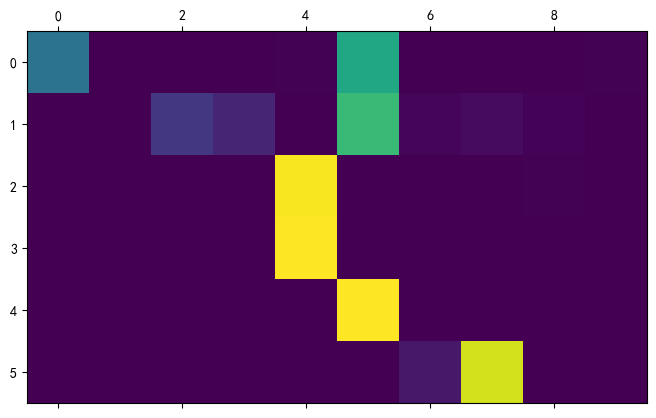

In [22]:
import matplotlib.pyplot as plt
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "你 只 是 玩")
print(output_words)
plt.rcParams['font.sans-serif'] = ['KaiTi']  # 指定默认字体为楷体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False
plt.matshow(attentions.numpy())
plt.show()

input = 他 和 他 的 邻 居 相 处 
output = he is mean to be a <EOS>


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5224\3025779216.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5224\3025779216.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


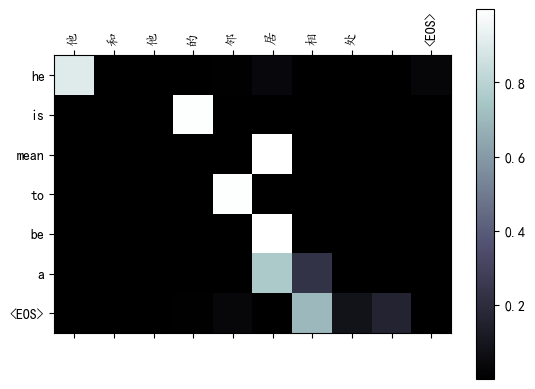

input =

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5224\3025779216.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5224\3025779216.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


 我 肯 定 他 会 成 功 的 
output = you are not a coward <EOS>


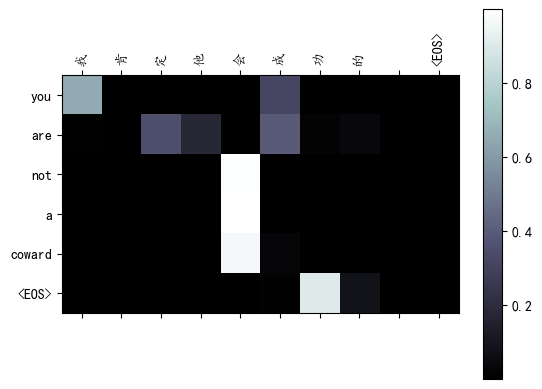

input = 他 總 是 忘 記 事 情
output = he is poor at the game <EOS>


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5224\3025779216.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5224\3025779216.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


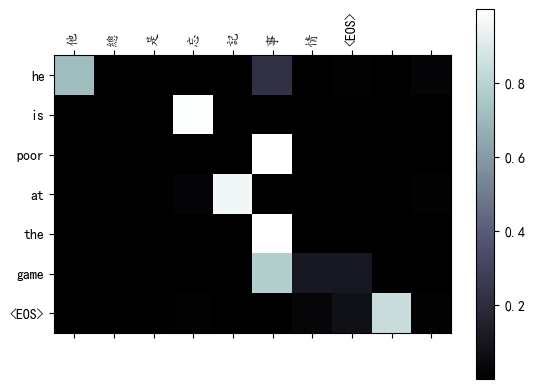

input = 我 们 非 常 需 要 食 物 
output = he is poor at top <EOS>


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5224\3025779216.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5224\3025779216.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


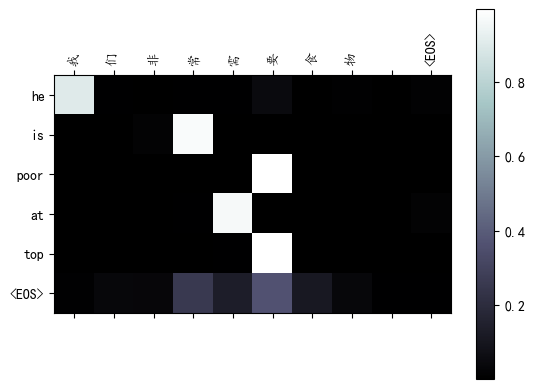

In [23]:
import matplotlib.pyplot as plt
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("他 和 他 的 邻 居 相 处 ")

evaluateAndShowAttention("我 肯 定 他 会 成 功 的 ")

evaluateAndShowAttention("他 總 是 忘 記 事 情")

evaluateAndShowAttention("我 们 非 常 需 要 食 物 ")